In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data import *
from preprocess import *
from skimage import filters
from random import choice
from scipy import signal
from skimage.color import gray2rgb

In [252]:
s_areas = ['.'.join([c1, c2, 'jpg'])
           for c1, c2, ext in map(lambda x: x.split('.'), os.listdir('dataset_original')) 
           if ext == 'csv']
s_areas

['20.623.jpg',
 '22.713.jpg',
 '33.924.jpg',
 '36.583.jpg',
 '37.823.jpg',
 '38.342.jpg',
 '43.564.jpg',
 '44.502.jpg',
 '49.17.jpg',
 '51.691.jpg',
 '52.449.jpg',
 '56.566.jpg',
 '58.937.jpg',
 '59.068.jpg',
 '59.3.jpg']

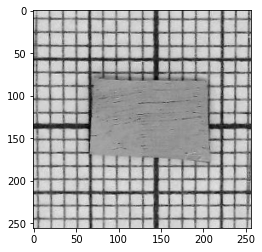

In [139]:
filename = choice(s_areas)
image = np.array(image_open(path.join('dataset_original', filename)))
img = align(rgb2gray(image))
plt.imshow(img, cmap='gray')

In [140]:
df_scale = pd.read_csv(path.join('dataset_original', '.'.join((*filename.split('.')[:-1], 'csv'))))
df_scale

,,Angle,Length
0,1,1.847,155.143
1,2,1.824,156.079
2,3,92.186,157.062
3,4,91.481,156.021


In [141]:
T = df_scale.Length.mean()/10
f = 1/T
T, f

(15.607624999999999, 0.06407124722691633)

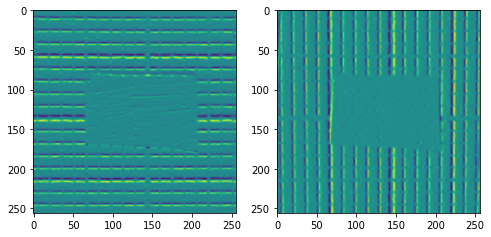

In [162]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

far_h = filters.farid_h(img)
far_v = filters.farid_v(img)

axs[0].imshow(far_h)
axs[1].imshow(far_v)

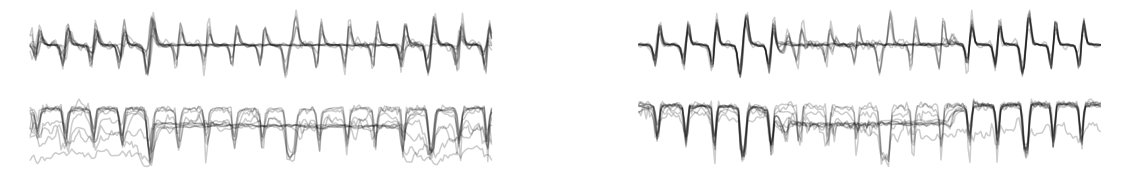

In [163]:
fig, axs = plt.subplots(2, 2, figsize=(20, 3))
for ax in axs.flat: ax.axis('off')

for i in np.random.randint(0, len(img), 10):
    axs[0][0].plot(far_v[i], 'k-', alpha=0.2)
    axs[0][1].plot(far_h.T[i], 'k-', alpha=0.2)
    axs[1][0].plot(img[i], 'k-', alpha=0.2)
    axs[1][1].plot(img.T[i], 'k-', alpha=0.2)

plt.show()

In [144]:
def autocorr(x, mode='full'):
    return np.correlate(x, x, mode=mode)

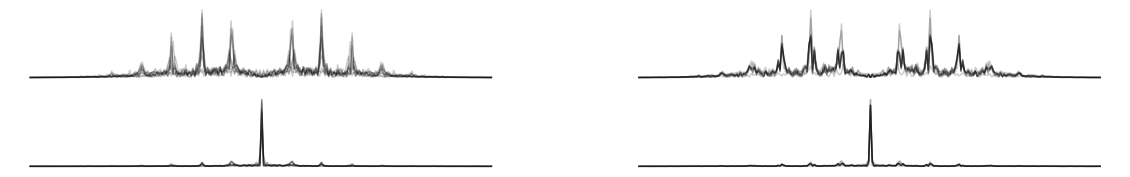

In [146]:
fig, axs = plt.subplots(2, 2, figsize=(20, 3))
for ax in axs.flat: ax.axis('off')

freq = np.fft.fftshift(np.fft.fftfreq(256, 1))

for i in np.random.randint(0, len(img), 10):
    axs[0][0].plot(freq, np.abs(np.fft.fftshift(np.fft.fft(far_v[i]))), 'k-', alpha=0.2)
    axs[0][1].plot(freq, np.abs(np.fft.fftshift(np.fft.fft(far_h.T[i]))), 'k-', alpha=0.2)
    axs[1][0].plot(freq, np.abs(np.fft.fftshift(np.fft.fft(img[i]))), 'k-', alpha=0.2)
    axs[1][1].plot(freq, np.abs(np.fft.fftshift(np.fft.fft(img.T[i]))), 'k-', alpha=0.2)

plt.show()

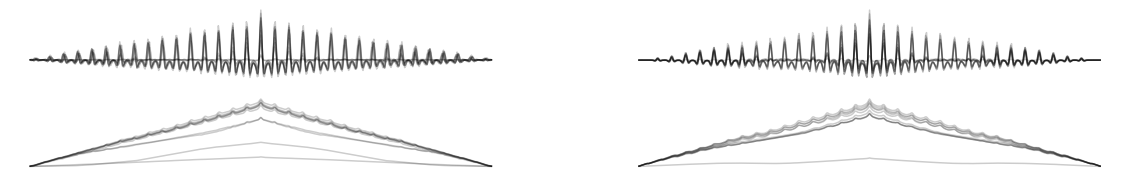

In [147]:
fig, axs = plt.subplots(2, 2, figsize=(20, 3))
for ax in axs.flat: ax.axis('off')

for i in np.random.randint(0, len(img), 10):
    axs[0][0].plot(autocorr(far_v[i]), 'k-', alpha=0.2)
    axs[0][1].plot(autocorr(far_h.T[i]), 'k-', alpha=0.2)
    axs[1][0].plot(autocorr(img[i]), 'k-', alpha=0.2)
    axs[1][1].plot(autocorr(img.T[i]), 'k-', alpha=0.2)

plt.show()

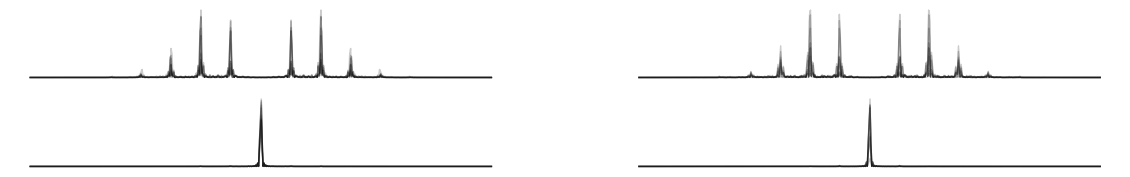

In [148]:
fig, axs = plt.subplots(2, 2, figsize=(20, 3))
for ax in axs.flat: ax.axis('off')

freq = np.fft.fftshift(np.fft.fftfreq(256*2, 0.5)[:-1])

for i in np.random.randint(0, len(img), 10):
    axs[0][0].plot(freq, np.abs(np.fft.fftshift(np.fft.fft(autocorr(far_v[i])))), 'k-', alpha=0.2)
    axs[0][1].plot(freq, np.abs(np.fft.fftshift(np.fft.fft(autocorr(far_h.T[i])))), 'k-', alpha=0.2)
    axs[1][0].plot(freq, np.abs(np.fft.fftshift(np.fft.fft(autocorr(img[i])))), 'k-', alpha=0.2)
    axs[1][1].plot(freq, np.abs(np.fft.fftshift(np.fft.fft(autocorr(img.T[i])))), 'k-', alpha=0.2)

plt.show()

[0.0625     0.12890625] [0.06640625 0.12890625]


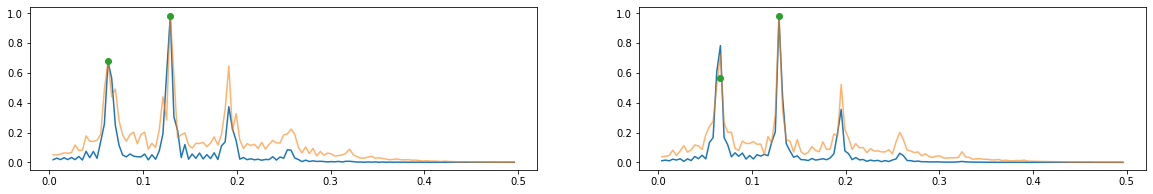

In [223]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))

freq = np.fft.fftfreq(256, 1)
loc = (freq > 0)

fft = lambda x: norm(np.abs(np.fft.fft(x))[loc])
auto_fft = lambda x: norm(np.abs(np.fft.fft(autocorr(x, 'same')))[loc])

I = np.random.randint(0, len(img), 20)

Yh = np.apply_along_axis(auto_fft, 0, far_h.T[I].T).mean(axis=1)
Yv = np.apply_along_axis(auto_fft, 0, far_v[I].T).mean(axis=1)

ax1.plot(freq[loc], Yh)
ax1.plot(freq[loc], np.apply_along_axis(fft, 0, far_h.T[I].T).mean(axis=1), alpha=0.6)
ax2.plot(freq[loc], Yv)
ax2.plot(freq[loc], np.apply_along_axis(fft, 0, far_v[I].T).mean(axis=1), alpha=0.6)

Ph = find_peaks(Yh, width=(1, 3), prominence=0.5)[0]
Fh = freq[loc][Ph]
ax1.plot(Fh, Yh[Ph], 'o')
Pv = find_peaks(Yv, width=(1, 3), prominence=0.5)[0]
Fv = freq[loc][Pv]
ax2.plot(Fv, Yh[Pv], 'o')

print(Fh, Fv)

plt.show()

In [153]:
F = [Fh.min(), Fv.min()]
np.mean(F), np.std(F)

(0.064453125, 0.001953125)

In [301]:
def find_scale(img, N=20):
    L = len(img)
    freq = np.fft.fftfreq(L, 1)
    loc = (freq > 0)
    auto_fft = lambda x: norm(np.abs(np.fft.fft(autocorr(x, 'same')))[loc])
    far = np.concatenate([filters.farid_v(img), filters.farid_h(img).T])
    Y = np.apply_along_axis(auto_fft, 0, far[np.random.randint(0, L, N)].T).mean(axis=1)
    P = find_peaks(Y, height=0.5)[0]
    return freq[loc][P].min()

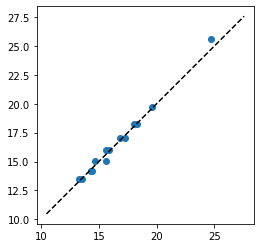

In [306]:
fig, ax = plt.subplots()

X,Y,A = [],[],[]
for filename in s_areas:
    image = np.array(image_open(path.join('dataset_original', filename)))
    img = align(rgb2gray(image))
    Y.append(1/find_scale(img, 50))
    df = pd.read_csv(path.join('dataset_original', '.'.join((*filename.split('.')[:-1], 'csv'))))
    X.append((df.Length.mean()/10))
    A.append(df.Angle)

X, Y = np.array(X), np.array(Y)
    
plt.plot(X, Y, 'o')
t = np.linspace(X.min()-0.25*X.ptp(), X.max()+0.25*X.ptp(), 100)
plt.plot(t, t, 'k--')
ax.set_aspect('equal')
plt.show()

In [304]:
np.mean(np.abs((X-Y)/Y*100))

1.4165813802083302